In [1]:
import blosc2
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
path = '/home/blosc/gaia/gaia-3d-windows-int8-3.b2nd'

In [3]:
arr = blosc2.open(path)
arr.info

{
    'blocksize': 15625,
    'clevel': 1,
    'codec': <Codec.ZSTD: 5>,
    'codec_meta': 0,
    'filters': [
        <Filter.NOFILTER: 0>,
        <Filter.NOFILTER: 0>,
        <Filter.NOFILTER: 0>,
        <Filter.NOFILTER: 0>,
        <Filter.NOFILTER: 0>,
        <Filter.SHUFFLE: 1>
    ],
    'filters_meta': [0, 0, 0, 0, 0, 0],
    'nthreads': 16,
    'splitmode': <SplitMode.ALWAYS_SPLIT: 1>,
    'typesize': 1,
    'use_dict': 0
}

{'nthreads': 16}

type,NDArray
shape,"(20000, 20000, 20000)"
chunks,"(250, 250, 250)"
blocks,"(25, 25, 25)"
dtype,uint8
cratio,1140.70
cparams,"{'codec': , 'codec_meta': 0, 'clevel': 1, 'use_dict': 0, 'typesize': 1, 'nthreads': 16, 'blocksize': 15625, 'splitmode': , 'filters': [, , , , , ], 'filters_meta': [0, 0, 0, 0, 0, 0]}"
dparams,{'nthreads': 16}


In [4]:
axis = 0
shape = arr.shape
chunks = arr.chunks
blocks = arr.blocks
#start = np.array([0, 0, 0])
start = np.array([8_000, 9_975, 9_975])
step = np.array([10, 50, 50])
nsegments = 15
max_factor = 4
min_factor = 1/4
incr = (max_factor - min_factor) / nsegments
incr

0.25

In [5]:
def init_array(arr, nsegments, start, step, axis):
    arrays = []
    start_aux = start.copy()
    for j in range(nsegments):
        sl = arr[start_aux[0]: start_aux[0] + step[0], start_aux[1]:start_aux[1] + step[1], 
                 start_aux[2]:start_aux[2] + step[2]]
        arrays.append(sl)
        start_aux[axis] += step[axis]

    return arrays

In [6]:
def update_array(arr, nsegments, start, step, axis, arrays):
    new_arrays = arrays[1:]
    
    start_aux = start.copy()
    start_aux += (step[axis] * nsegments)
    sl = arr[start_aux[0]: start_aux[0] + step[0], start_aux[1]:start_aux[1] + step[1], 
             start_aux[2]:start_aux[2] + step[2]]
    new_arrays.append(sl)

    return new_arrays

In [7]:
range_x = [0, step[-1]]
range_x[0] -= 3
range_x[1] += 3
range_y = [0, step[-1]]
range_y[0] -= 3
range_y[1] += 3
st = 0.2

In [8]:
frames_path = '../frames_overlap_galaxy/'
niter = 0
while start[axis] + step[axis] < shape[axis] and range_x[0] < range_x[1]:
    #print("start ", start)
    #print("stop ", stop)
    factor = max_factor
    #print("factor ", factor)
    if niter == 0:
        # print("abans start ", start)
        arrays = init_array(arr, nsegments, start, step, axis) 
        # print("dp start ", start)
    for j in range(nsegments):
        #if niter < 2:
        #    print("start ", start)
        #    print("stop ", start+ step)
        #    print("factor ", factor)
        #else:
        #    break
        
        sl = arrays[j] * factor
        if j > 1:
            np_arrs = np.concatenate([np_arrs, sl], axis=axis)
        elif j == 1:
            np_arrs = np.concatenate([aux, sl], axis=axis) 

        aux = sl
        factor -= incr
    
    img = np.sum(np_arrs, axis=axis) 
    #if niter == 2:
    #    break
    
    # -------- Create frame and save it on disk ----------------------------------------
    idx = np.indices(img.shape)
    fig = px.scatter(x=idx[0, :, :].flatten(), y=idx[1, :, :].flatten(), 
                       size=img.flatten(), range_x=range_x, range_y=range_y,
                    color_discrete_sequence=['white'], opacity=0.8
                    )
    fig.update_traces(marker=dict(symbol="star"))
    fig.update_layout(plot_bgcolor="black", paper_bgcolor='white')
    # fig.show()
    fig.write_image(frames_path + "{0}.png".format(niter))
    # ----------------------------------------------------------------------------------
    range_x[0] += st
    range_y[0] += st
    range_x[1] -= st
    range_y[1] -= st

    niter += 1
    arrays = update_array(arr, nsegments, start, step, axis, arrays)
    start[axis] += step[axis]
niter

140

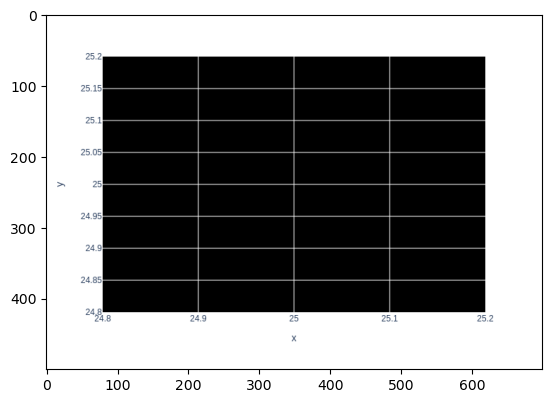

In [9]:
filename = "factor_intent_step10_nseg15_st0_2"


frames = [] # for storing the generated images
fig = plt.figure()
for i in range(niter):
    img = plt.imread(frames_path + "{0}.png".format(i))
    frames.append([plt.imshow(img, animated=True)])
ani = animation.ArtistAnimation(fig, frames,
                                repeat_delay=1000)
ani.save(filename="./" + filename + ".html", writer="html")
ani.save(filename="./" + filename + ".gif", writer="pillow")

plt.show()